In [1]:
%matplotlib notebook

import numpy as np
from scipy.integrate import solve_ivp
from numpy import pi
import matplotlib.pyplot as plt

from basics import *
from hybrid_matrix_elements import *
from atomic_physics import *

# Experiment Parameters

In [2]:
p_ge = 89e-3  # W
p_er = 53e-3  # W
w_ge = 15e-6  # mchroem
w_er = 5e-6  # m
pol_ge = SphericalVector([1,0,0])  # Z polarized
pol_er = SphericalVector([1,0,0])  # Z polarized
k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
nr = 60  # Target Rydberg State
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

bias_B = 5 * gauss # bias field in the z-direction

# Laser detunings
detuning = 2*pi*79.0e6  # Detuning from the ground-excited (F'=6) transition
# detuning = 2*pi*85.1e6
# Simulated AC start shifts
dAC = 0  # To target |nrP3/2,1/2> state
dAC = -1.7e6  # To target |nrP3/2,-1/2> state
delta = np.array([detuning - DET for DET in DHF])  # Intermediate detunings for each state
little_delta = zeeman_R(bias_B, nr, -1/2)+dAC  # two-photon detuning from unperturbed |nrP3/2> level

# Lists of quantum numbers being tracked
fs = range(1,7,1)  # Intermediate f levels
mfs = [-2,-1,0,1,2]  # Intermediate mf states being considered. Other mf's are uncoupled from light fields
mrs = np.arange(-3/2,3/2+1,1)  # Rydberg Zeeman states

In [16]:
def psi_sch(t, psi, hamiltonian):
    return -1j*np.dot(psi, hamiltonian)

dim = 1+28+4 # 1 ground, 28 excited, 4 rydberg
def find(f,mf):
    if abs(mf) > f:
        return -1
    if f == 1:
        return 3*f+mf-1
    else:
        return 5*f+mf-4
ryd_ind = lambda mr: int(mr + 3/2)+29

# Initialize hamiltonian and state
H = np.zeros((dim,dim),dtype=complex)
psi_0 = np.zeros(dim, dtype=complex)
psi_0[0] = 1


for f in fs:
    for mf in mfs:
        if abs(mf) > f:
            continue
        # print(f"|f,mf = {f,mf}>, ind = {find(f,mf)}")
        # Ground - Excited Rabi frequencies
        H[0,find(f,mf)] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, f, mf, phi_ge)/2
        H[find(f,mf),0] = H[0,find(f,mf)].conjugate()
        # Detuning from intermediate state
        # print(delta[f])
        H[find(f,mf),find(f,mf)] = delta[f] - zeeman_e(bias_B, f, mf)
        
        # Excited - Rydberg Rabi frequencies
        for mr in mrs:
            #print(mr,ryd_ind(mr))
            H[find(f,mf),ryd_ind(mr)] = d_rabi_frequency(p_er, w_er, pol_er, nr, f, mf, mr, phi_er)/2
            H[ryd_ind(mr),find(f,mf)] = H[find(f,mf),ryd_ind(mr)].conjugate()
            H[ryd_ind(mr),ryd_ind(mr)] = little_delta - zeeman_R(bias_B, nr, mr)

In [17]:
def frequency_sweep(hamiltonian, psi_i, detuned_states, detunings, times):
    ys = np.zeros((len(psi_i), len(detunings), len(times)),dtype=complex)  # List of all state coefficients at all times at each detuning
    hamiltonian_p = hamiltonian.copy()  # Make deep copy
    for i, det in enumerate(detunings):
        for ind in detuned_states:
            hamiltonian_p[ind,ind] = hamiltonian[ind,ind] + det

        sol = solve_ivp(
            lambda t, y : psi_sch(t, y, hamiltonian_p),
            (min(times),max(times)),
            psi_0,
            t_eval = times
        )

        ys[:,i,:] = sol.y
    return ys

ts = np.linspace(0,1.6e-6,1000)  # Times to evaluate our solutions
detunings = np.linspace(-80.0e6, 100e6, 81)  # Detunings to test

ys = frequency_sweep(H, psi_0, [ryd_ind(mr) for mr in mrs], detunings, ts)
Ps = np.abs(ys)**2

<IPython.core.display.Javascript object>


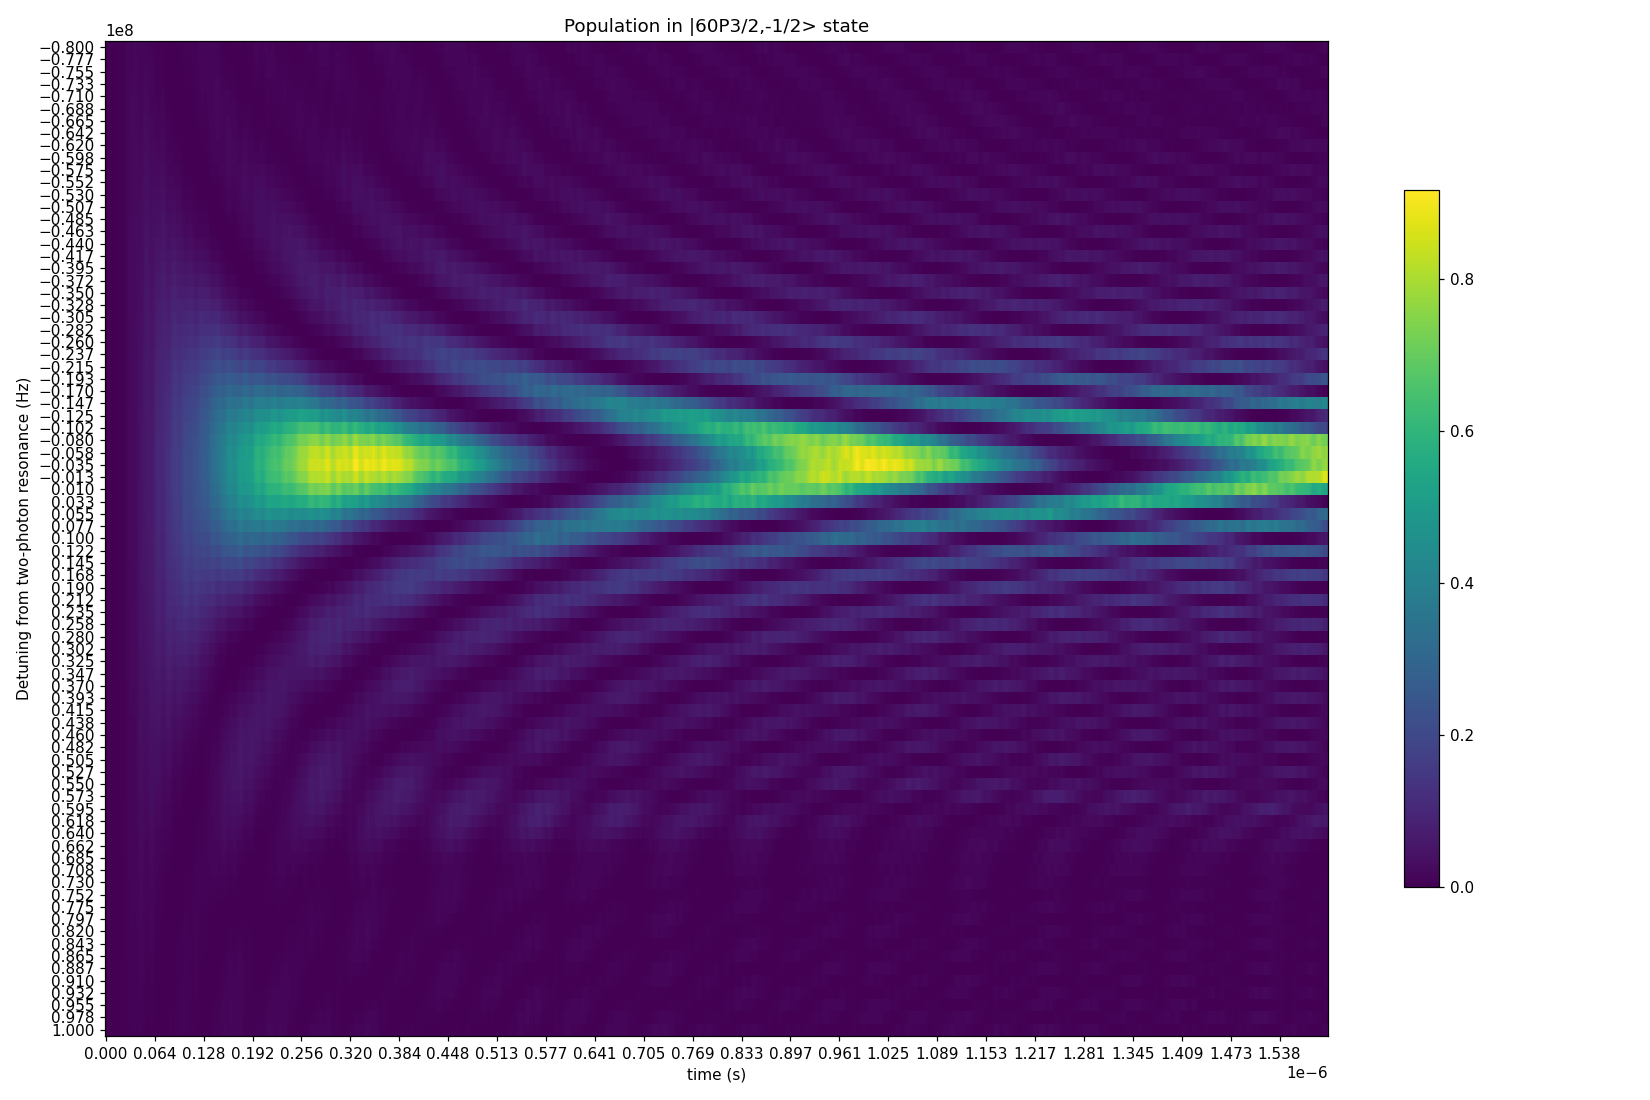

In [18]:
PT = Ps[ryd_ind(-1/2)]
fig,ax = plt.subplots(1,1,figsize=(15,10))
detuning_steps = detunings[1] - detunings[0]
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(detunings + detuning_steps / 2),  # bottom
    min(detunings - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning from two-photon resonance (Hz)")
ax.set_xticks(ts[::40])
ax.set_yticks(detunings)
ax.set_title(f"Population in |{nr}P3/2,-1/2> state")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()
fig.savefig("PiPulsetom1.png")

<IPython.core.display.Javascript object>


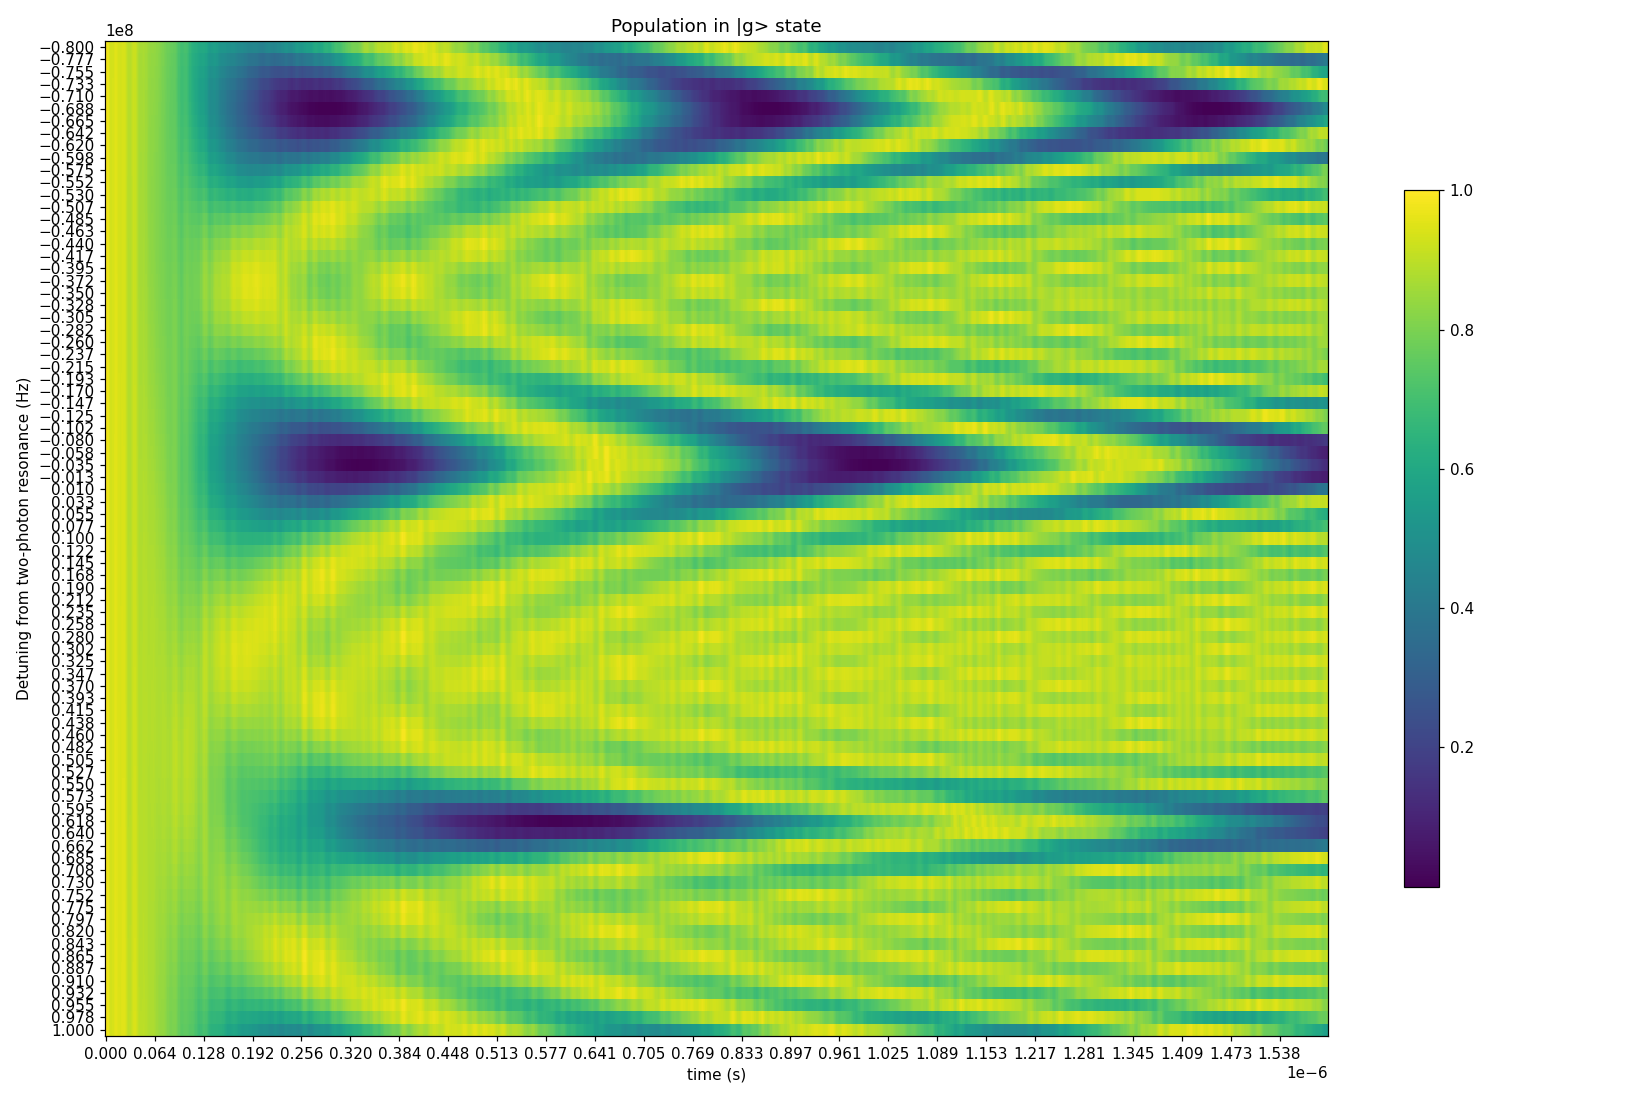

In [19]:
PT = Ps[ryd_ind(-1/2)*0]
fig,ax = plt.subplots(1,1,figsize=(15,10))
detuning_steps = detunings[1] - detunings[0]
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(detunings + detuning_steps / 2),  # bottom
    min(detunings - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning from two-photon resonance (Hz)")
ax.set_xticks(ts[::40])
ax.set_yticks(detunings)
ax.set_title(f"Population in |g> state")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()
fig.savefig("PiPulseg.png")

<IPython.core.display.Javascript object>


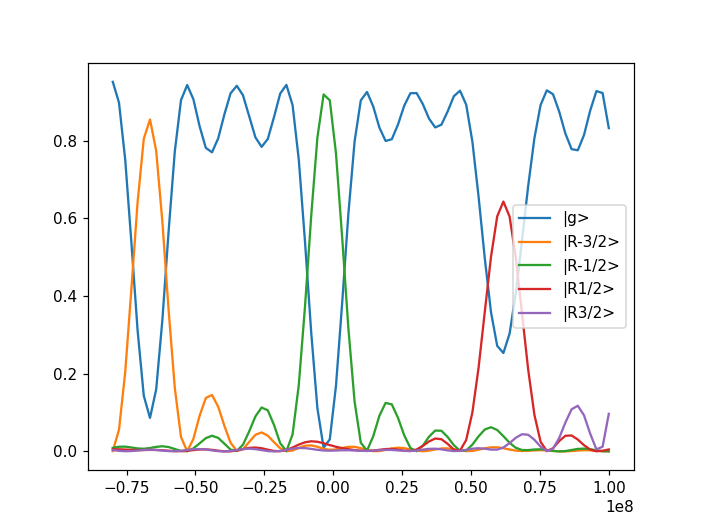

In [20]:
fig,ax = plt.subplots(1,1)
tpi = 0.384e-6
t_pi = np.where(abs(ts-tpi) == min(abs(ts-tpi)))[0][0]
Ps = np.abs(ys)**2
ax.plot(detunings,Ps[0,:,t_pi],label=f"|g>")
for mr in mrs:
    ax.plot(detunings,Ps[ryd_ind(mr),:,t_pi],label=f"|R{int(2*mr)}/2>")
ax.legend()
fig.show()

<IPython.core.display.Javascript object>


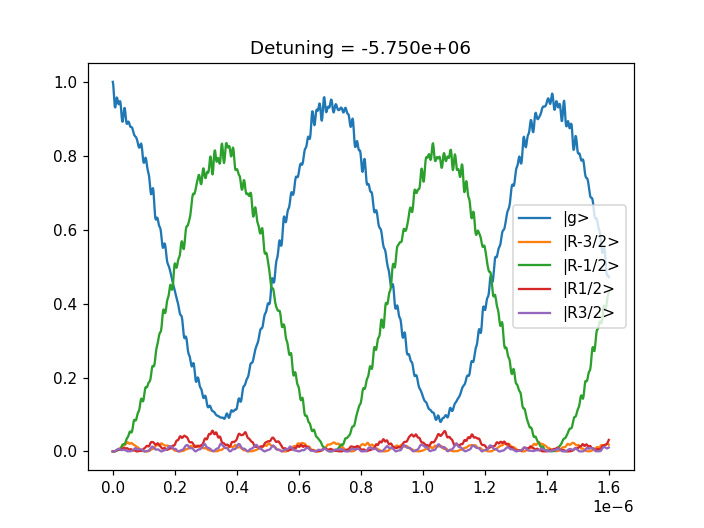

<IPython.core.display.Javascript object>


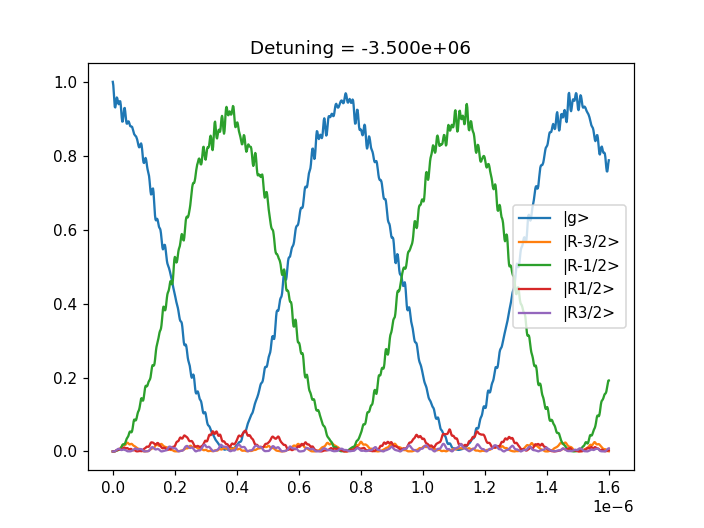

<IPython.core.display.Javascript object>

In [22]:
det_choice = -3.6e6 # MHz
det_ind = np.where(abs(detunings-det_choice) == min(abs(detunings-det_choice)))[0][0]

'''detuning = detunings[det_ind]
y = ys[:,det_ind,:]

fig,ax = plt.subplots(1,1)
ax.plot(ts,np.abs(y[0])**2,label = f"|g>")
for mr in mrs:
    ax.plot(ts,np.abs(y[ryd_ind(mr)])**2,label = f"|R{2*mr:.0f}/2>")
ax.set_title(f"Detuning = {detuning:.3e}")
ax.legend()
fig.show()
'''

for det_offset in range(-1,2,1):
    detuning = detunings[det_ind + det_offset]
    y = ys[:,det_ind + det_offset,:]

    fig,ax = plt.subplots(1,1)
    ax.plot(ts,np.abs(y[0])**2,label = f"|g>")
    for mr in mrs:
        ax.plot(ts,np.abs(y[ryd_ind(mr)])**2,label = f"|R{2*mr:.0f}/2>")
    ax.set_title(f"Detuning = {detuning:.3e}")
    ax.legend()
    fig.show()


<IPython.core.display.Javascript object>


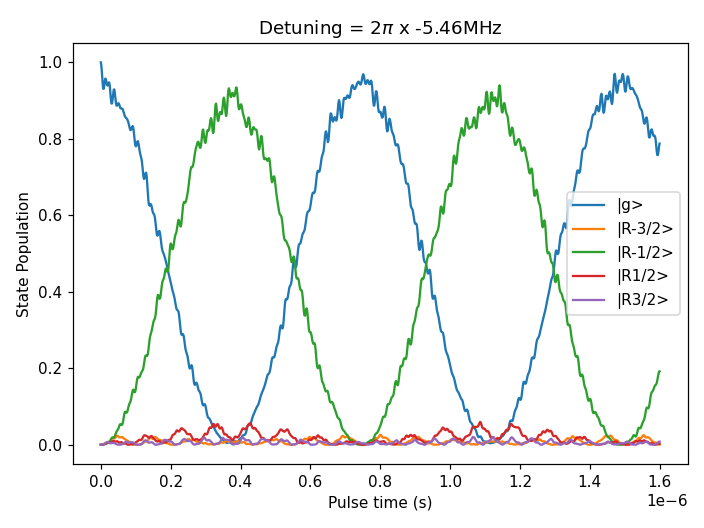

In [24]:
det_choice = -3.6e6 # -25.8 MHz
det_ind = np.where(abs(detunings-det_choice) == min(abs(detunings-det_choice)))[0][0]

detuning = detunings[det_ind]
y = ys[:,det_ind,:]

fig,ax = plt.subplots(1,1)
ax.plot(ts,np.abs(y[0])**2,label = f"|g>")
for mr in mrs:
    ax.plot(ts,np.abs(y[ryd_ind(mr)])**2,label = f"|R{2*mr:.0f}/2>")
ax.set_title(f"Detuning = 2$\pi$ x {(little_delta + detuning)/(2*pi)*1e-6:.2f}MHz")
ax.legend()
ax.set_ylabel("State Population")
ax.set_xlabel("Pulse time (s)")
fig.tight_layout()
fig.show()
fig.savefig("ResonantTwoPhotonRabi.png")

<IPython.core.display.Javascript object>


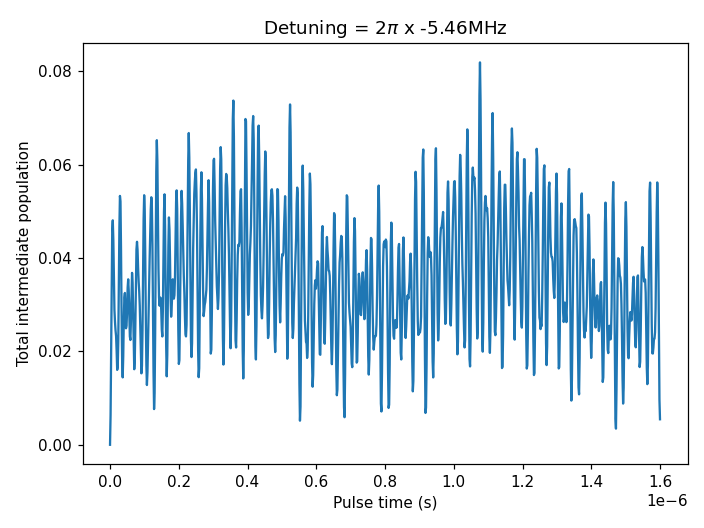

In [25]:
det_choice = -3.6e6 # -25.8 MHz
det_ind = np.where(abs(detunings-det_choice) == min(abs(detunings-det_choice)))[0][0]

detuning = detunings[det_ind]
y = ys[:,det_ind,:]

fig,ax = plt.subplots(1,1)
ax.plot(ts,(np.abs(y[find(1,-1):find(6,1)])**2).sum(0),label = f"|e>")
ax.set_title(f"Detuning = 2$\pi$ x {(little_delta + detuning)/(2*pi)*1e-6:.2f}MHz")
# ax.legend()
ax.set_ylabel("Total intermediate population")
ax.set_xlabel("Pulse time (s)")
fig.tight_layout()
fig.show()
fig.savefig("Intermediate populations.png")

<IPython.core.display.Javascript object>


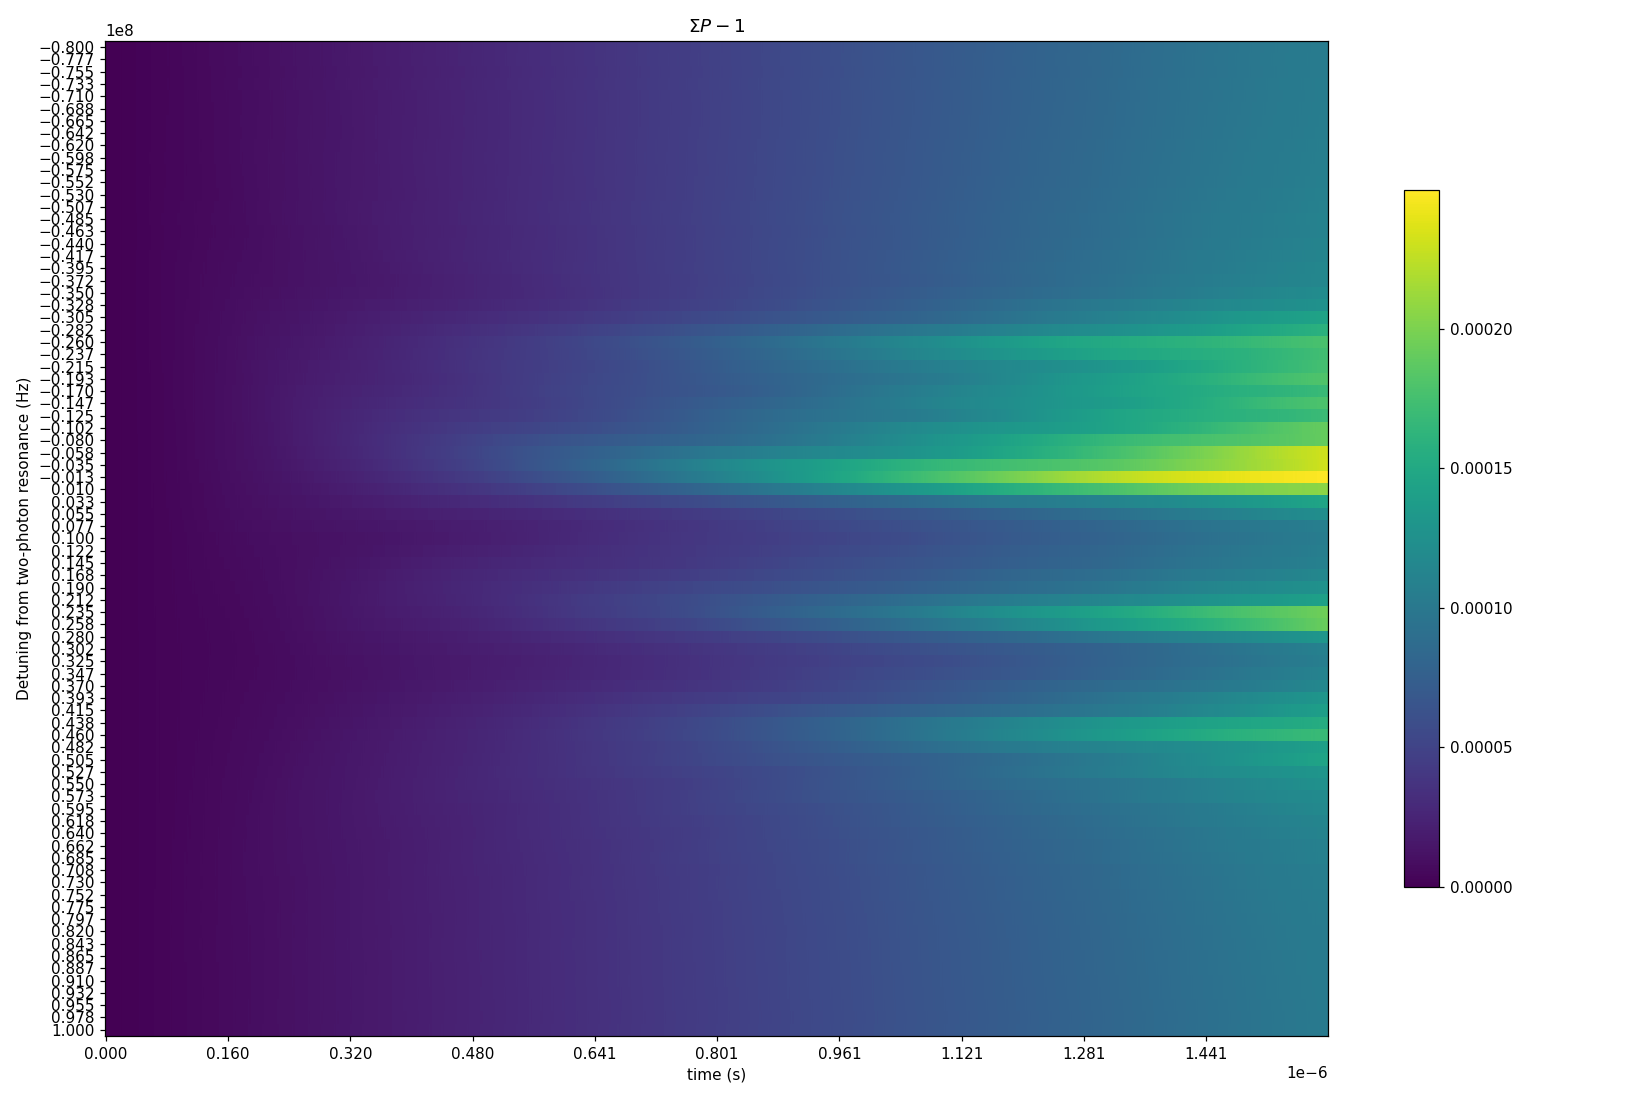

In [89]:
PT = Ps.sum(0)-1
fig,ax = plt.subplots(1,1,figsize=(15,10))
detuning_steps = detunings[1] - detunings[0]
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(detunings + detuning_steps / 2),  # bottom
    min(detunings - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning from two-photon resonance (Hz)")
ax.set_xticks(ts[::100])
ax.set_yticks(detunings)
ax.set_title("$\Sigma P - 1$")
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.tight_layout()
fig.show()
fig.savefig("ExtraPopulations.png")

<IPython.core.display.Javascript object>


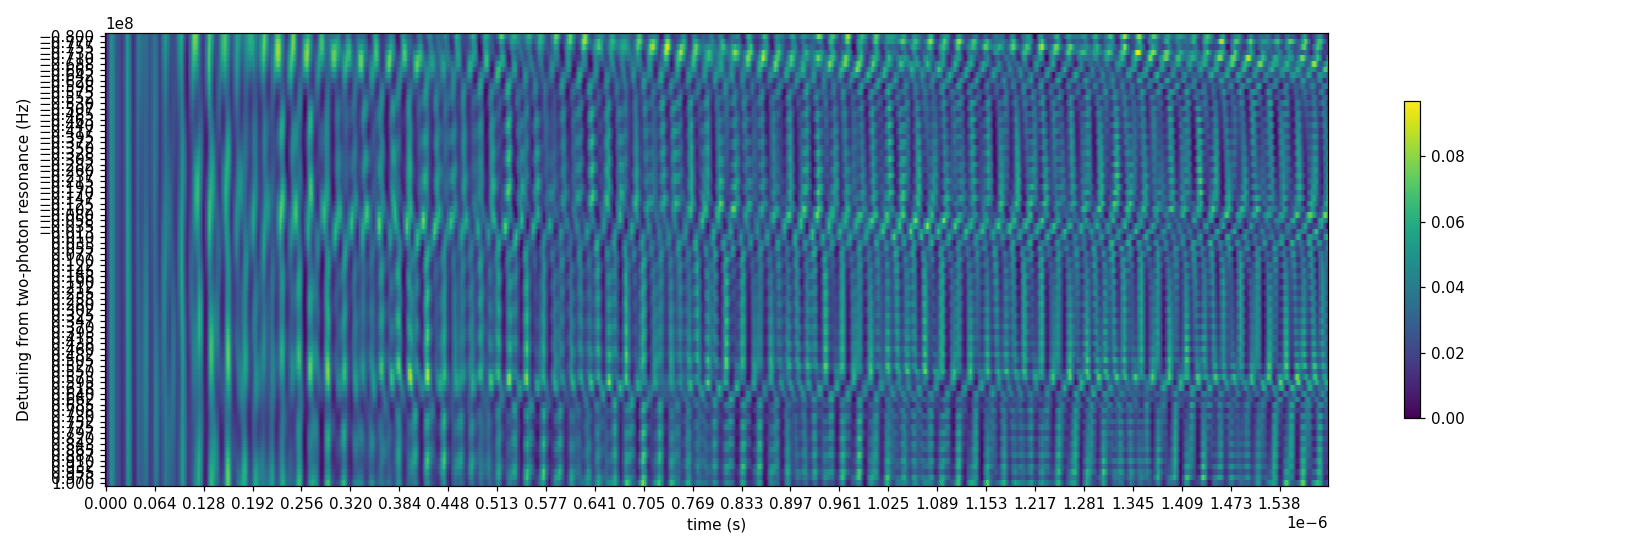

In [23]:
PT = Ps[find(1,-1):find(6,1)].sum(0)
fig,ax = plt.subplots(1,1,figsize=(15,5))
detuning_steps = detunings[1] - detunings[0]
ts_steps = ts[1] - ts[0]
extent = [
    min(ts - ts_steps / 2),  # left
    max(ts + ts_steps / 2),  # right
    max(detunings + detuning_steps / 2),  # bottom
    min(detunings - detuning_steps / 2)   # top
]
im = ax.imshow(PT, interpolation='none', aspect='auto', extent=extent)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning from two-photon resonance (Hz)")
ax.set_xticks(ts[::40])
ax.set_yticks(detunings)
fig.tight_layout()
fig.colorbar(im, ax=ax, use_gridspec=True, shrink=.7)
fig.show()

# Chopped Frequency sweep over range of Detunings above

In [60]:
chops = 10  # chop 100 times
t_pulse = 1.0e-6  # length of rydberg pulse each chop
measurements = 300
t_pulse_ind = np.where(abs(ts-t_pulse) == min(abs(ts-t_pulse)))[0][0]
atoms = np.ones((len(detunings), measurements), dtype = int)
P_ryd = Ps[:,:,t_pulse_ind]
retention = 0.82

for chop in range(chops):
    for mr in mrs:
        P_mr = Ps[ryd_ind(mr),:,t_pulse_ind]
        # print(P_mr)
        for i, detuning in enumerate(detunings):
            # print(np.random.rand(measurements))
            atoms[i] *= (np.random.rand(measurements) > P_mr[i])
atoms *= (np.random.rand(*atoms.shape) < retention)

<IPython.core.display.Javascript object>


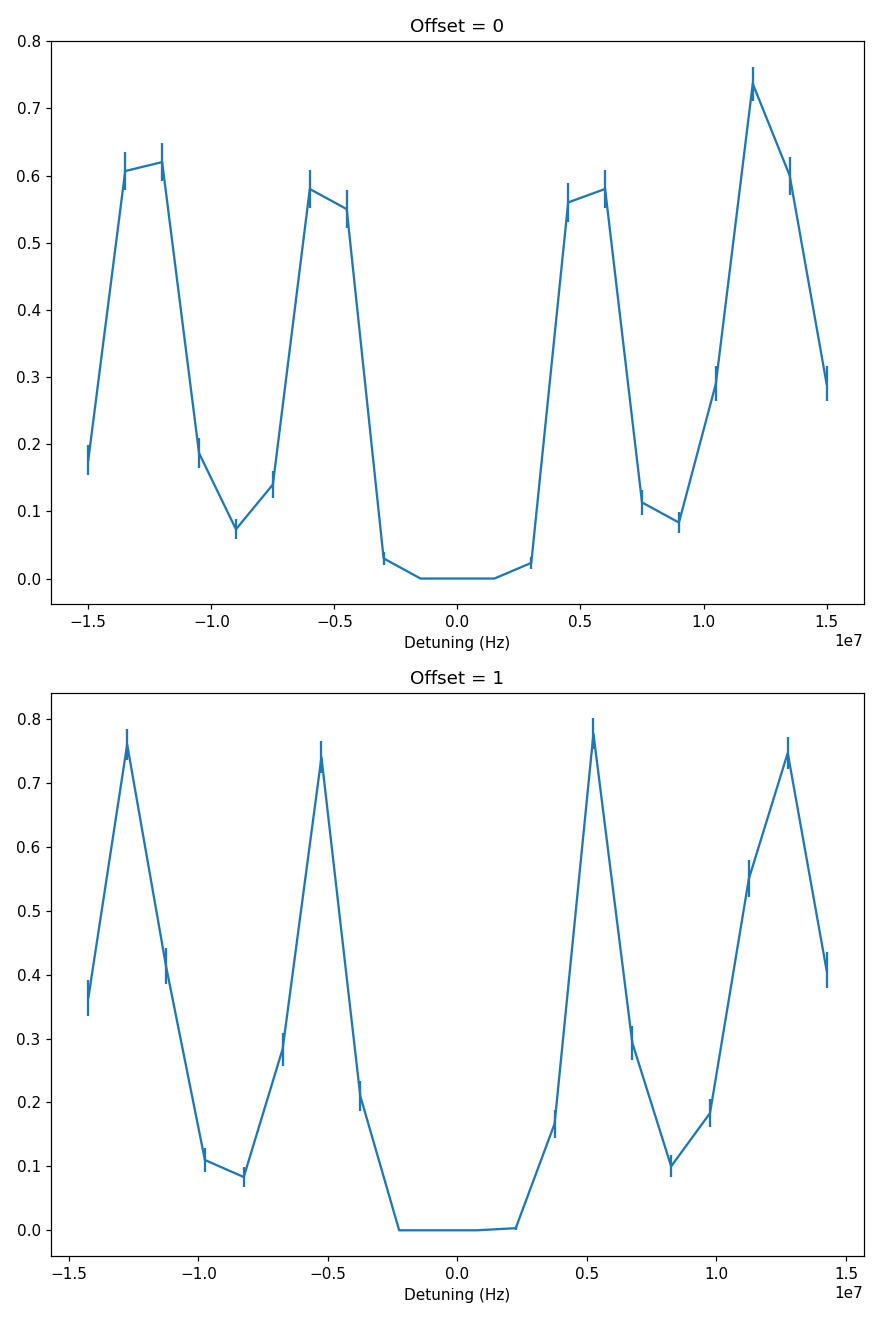

In [61]:
def shot_error(probability: float, samples: int):
    """
    Args:
        probability : number between 0 and 1. Measured probability of an event occurring
        samples : number of samples used to measure the ratio
    Returns:
        shot noise uncertainty. Uncertainty in probability due to statistical variations
    """
    return np.sqrt(probability*(1-probability)/samples)
sample_ratio = 2
fig,axar = plt.subplots(sample_ratio,1,figsize=(8,6*sample_ratio))
for i in range(sample_ratio):
    axar[i].errorbar(
        detunings[i::sample_ratio],
        (atoms.sum(1)/len(atoms[0]))[i::sample_ratio],
        shot_error(atoms.sum(1)/len(atoms[0]), len(atoms[0]))[i::sample_ratio],
    )
    axar[i].set_title(f"Offset = {i}")
    axar[i].set_xlabel("Detuning (Hz)")
fig.tight_layout()
fig.show()

In [110]:
detunings = np.linspace(-70.0e6, 30.0e6, 81) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


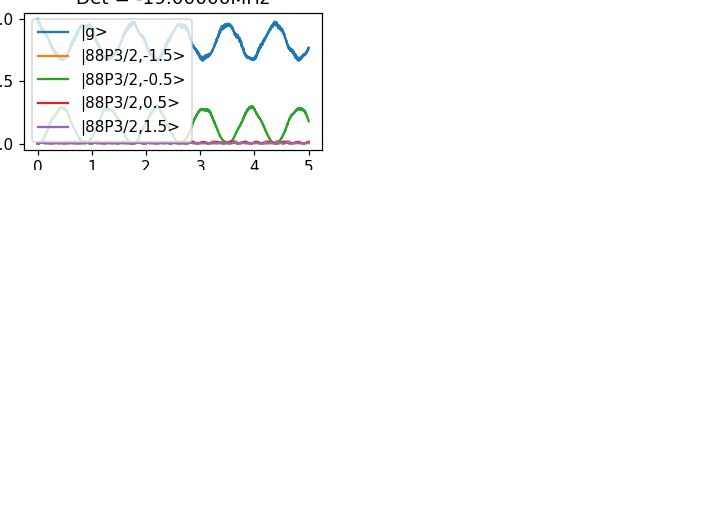

<IPython.core.display.Javascript object>


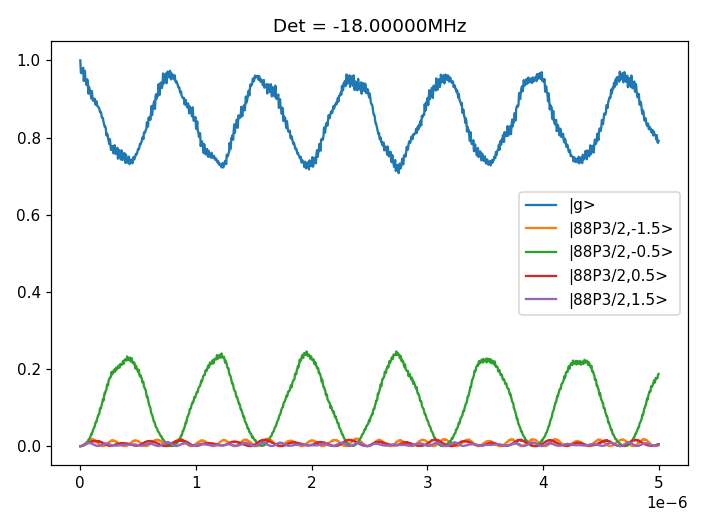

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


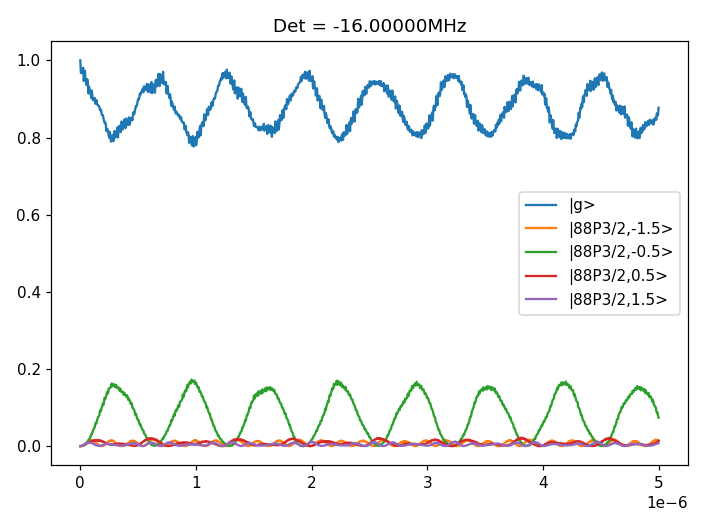

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


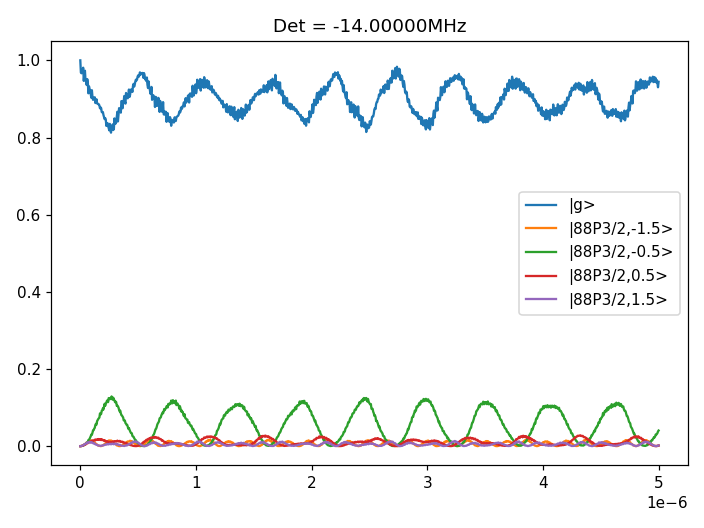

<IPython.core.display.Javascript object>


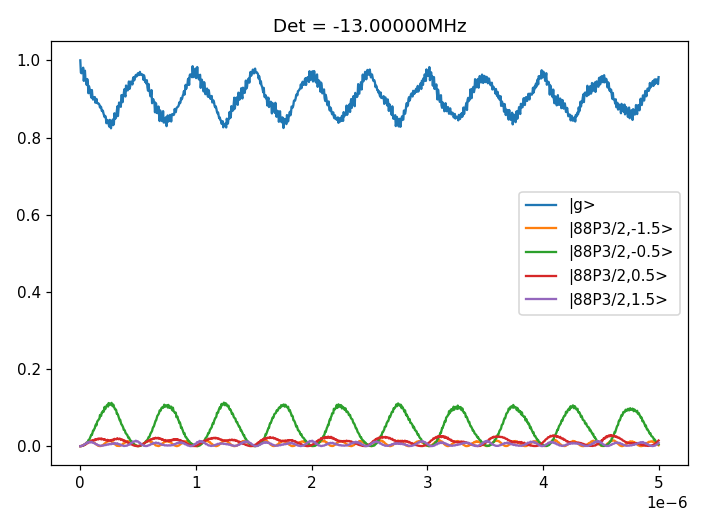

<IPython.core.display.Javascript object>


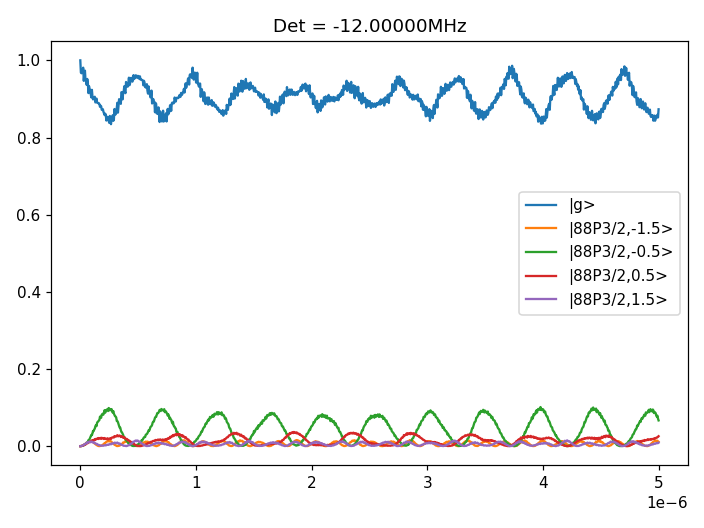

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


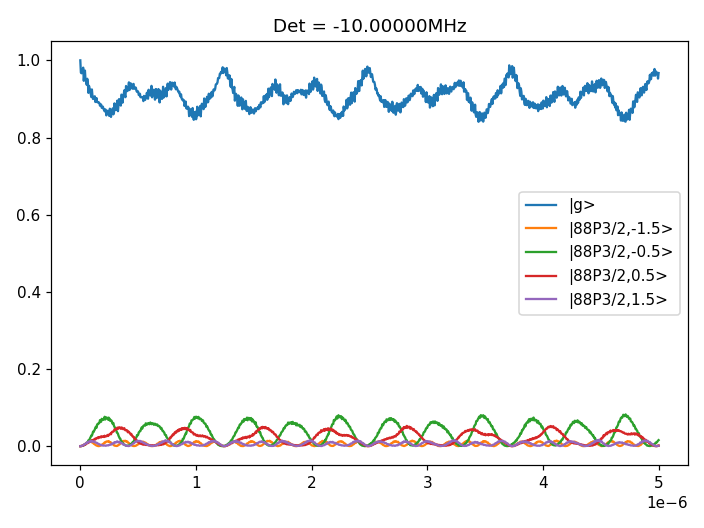

<IPython.core.display.Javascript object>


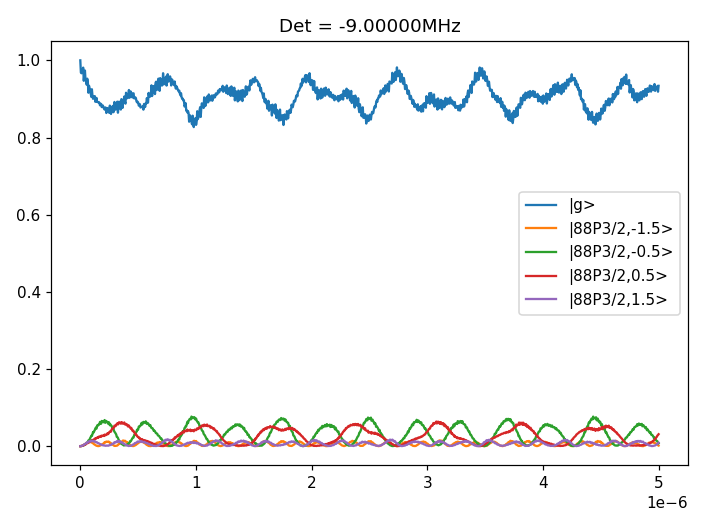

<IPython.core.display.Javascript object>


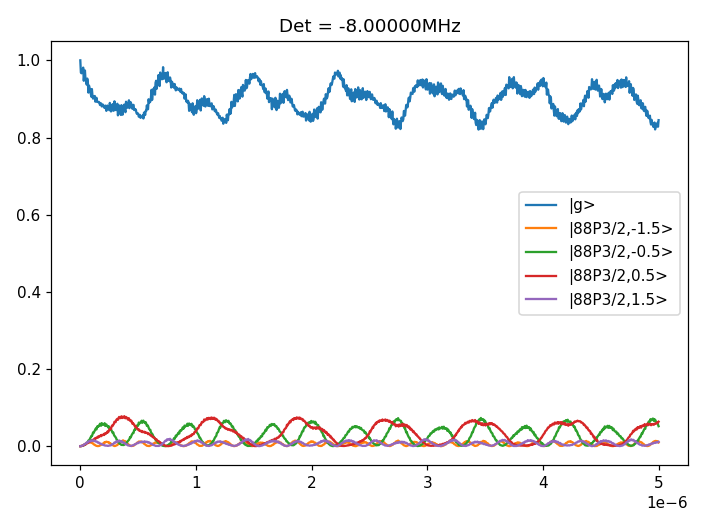

<IPython.core.display.Javascript object>


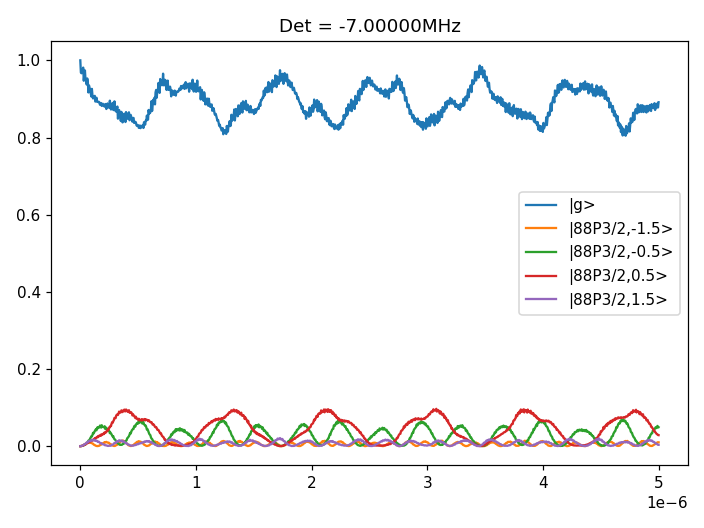

<IPython.core.display.Javascript object>


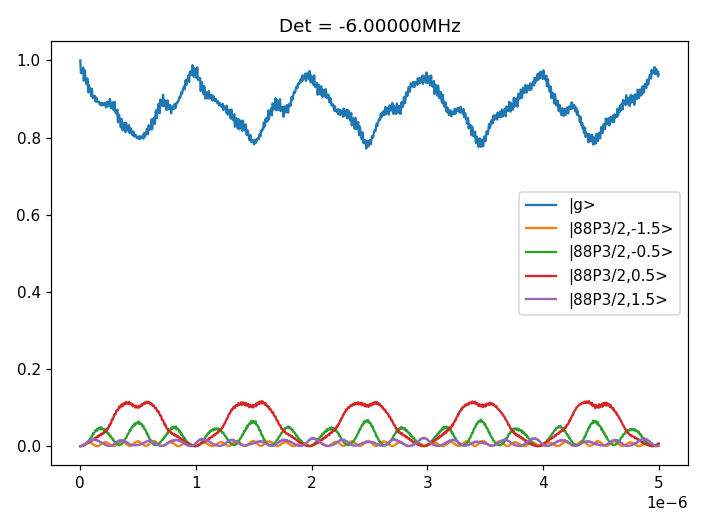

<IPython.core.display.Javascript object>


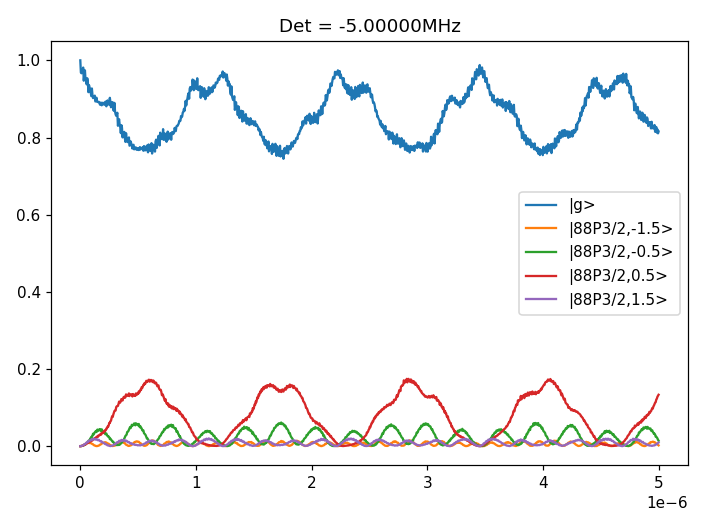

<ipython-input-21-d0bde1a8b161>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,1)


<IPython.core.display.Javascript object>


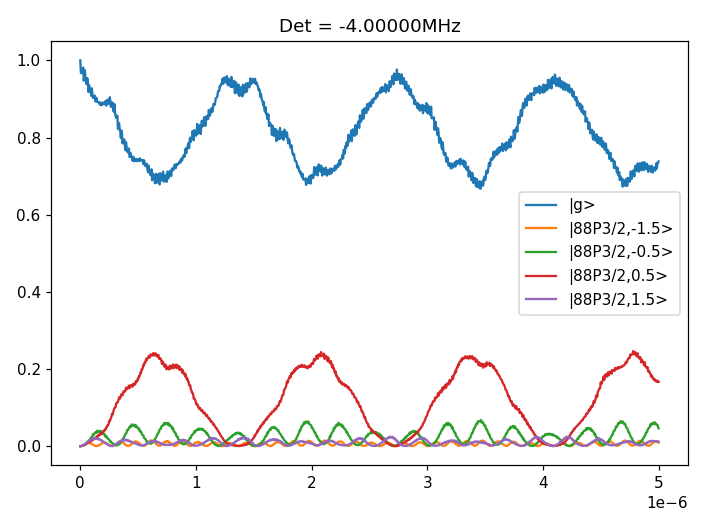

<IPython.core.display.Javascript object>


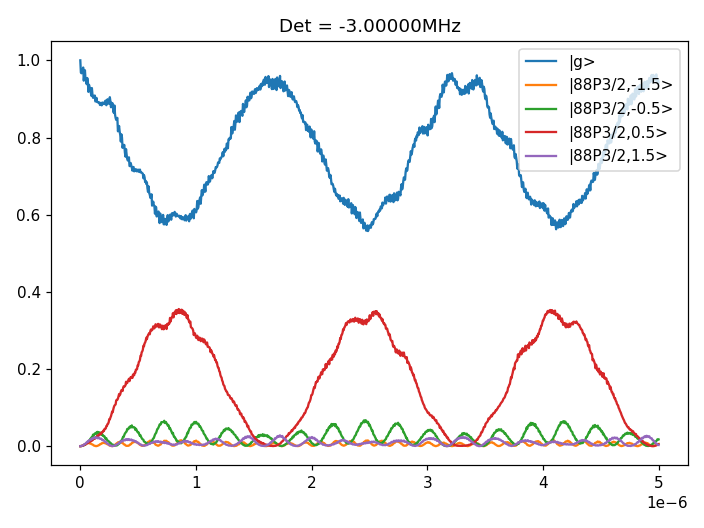

<IPython.core.display.Javascript object>


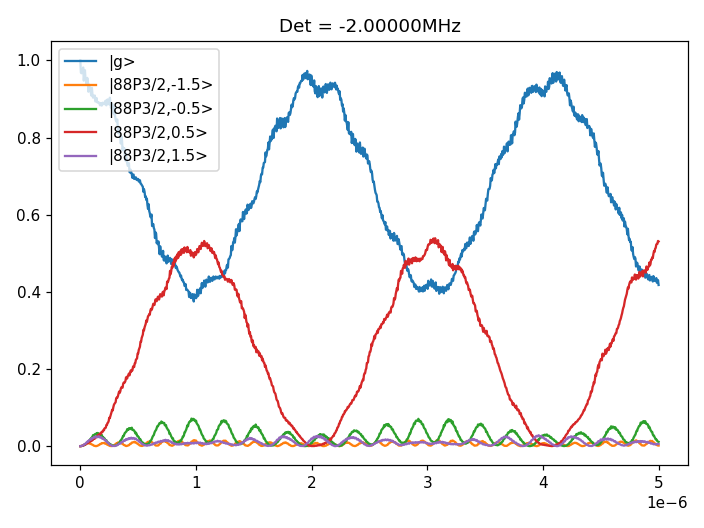

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


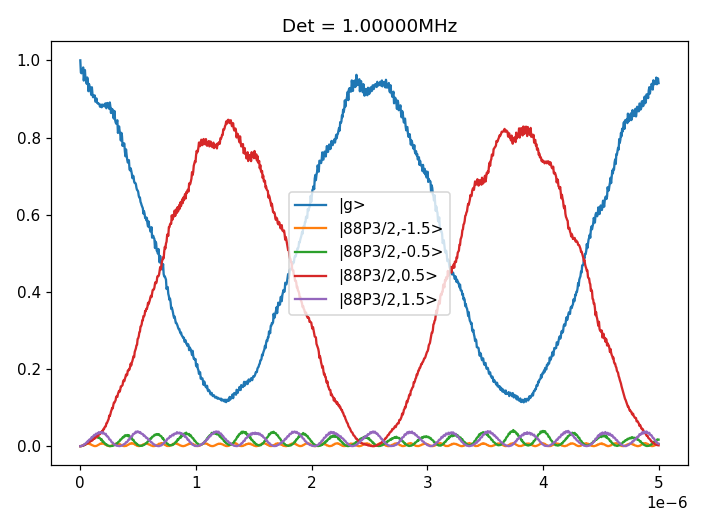

<IPython.core.display.Javascript object>


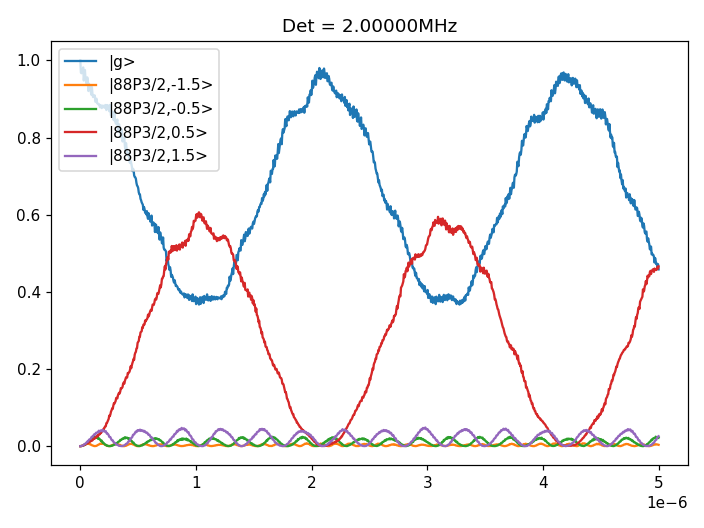

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


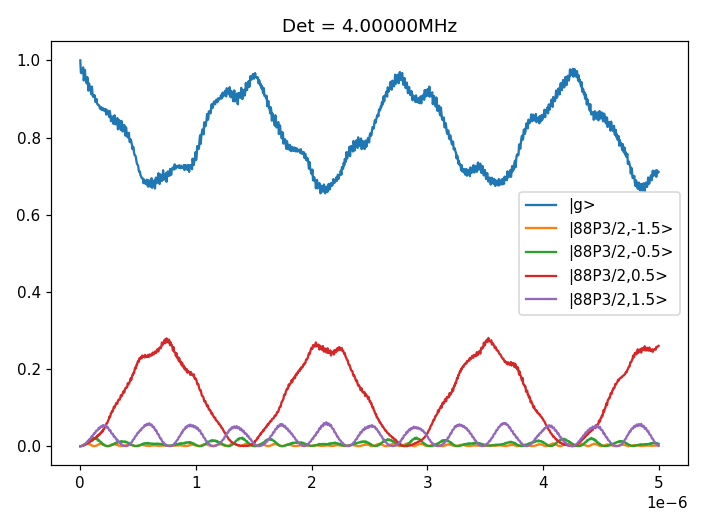

<IPython.core.display.Javascript object>


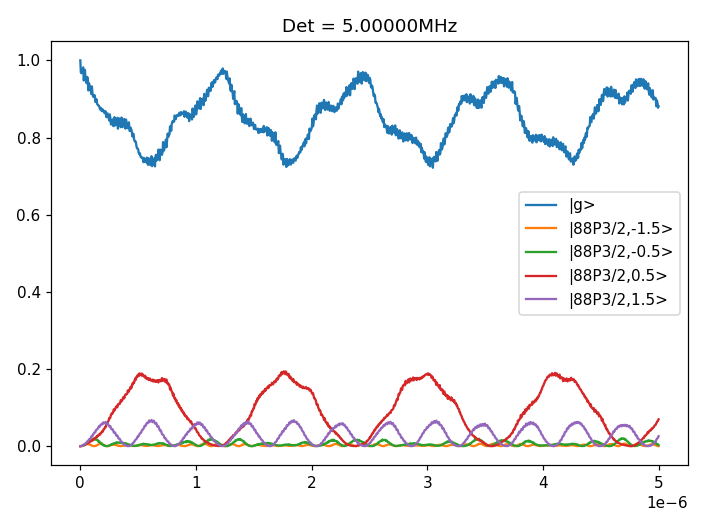

<IPython.core.display.Javascript object>


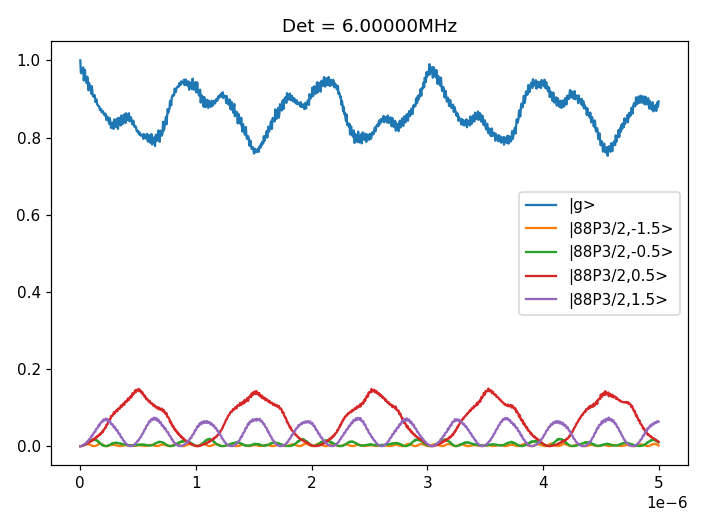

<IPython.core.display.Javascript object>


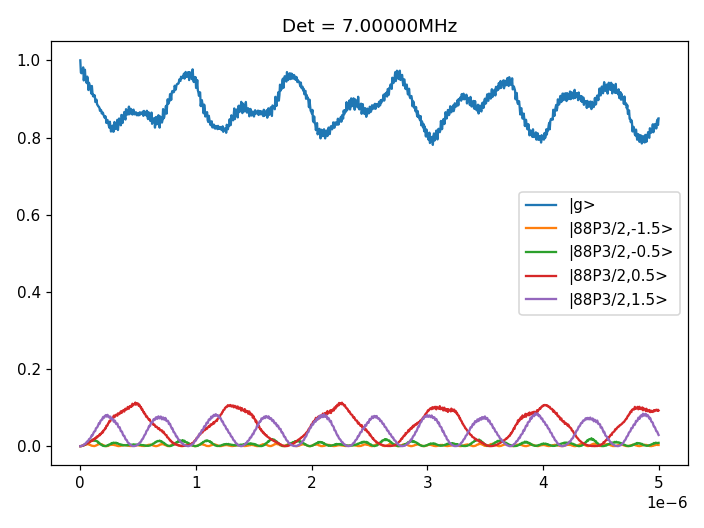

<IPython.core.display.Javascript object>


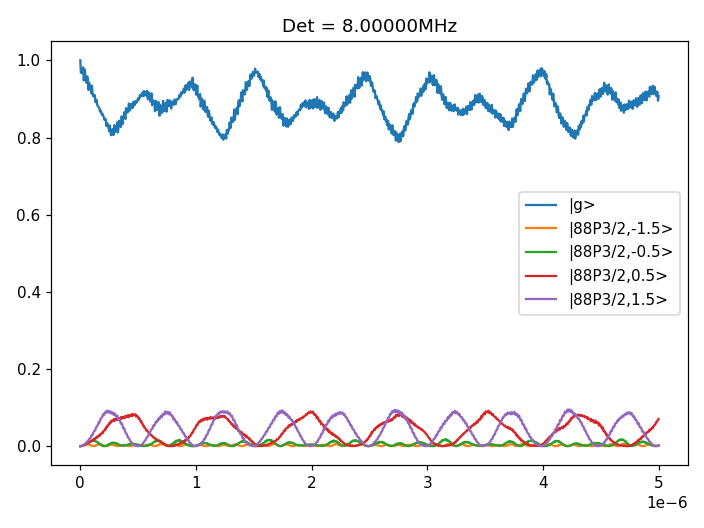

<IPython.core.display.Javascript object>


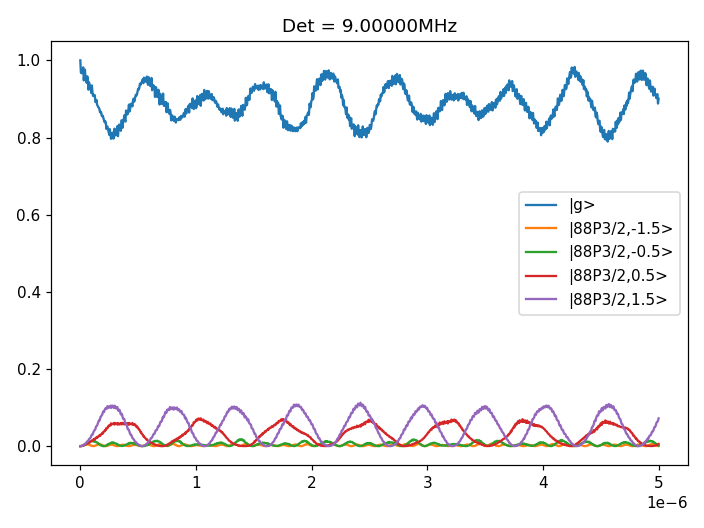

<IPython.core.display.Javascript object>


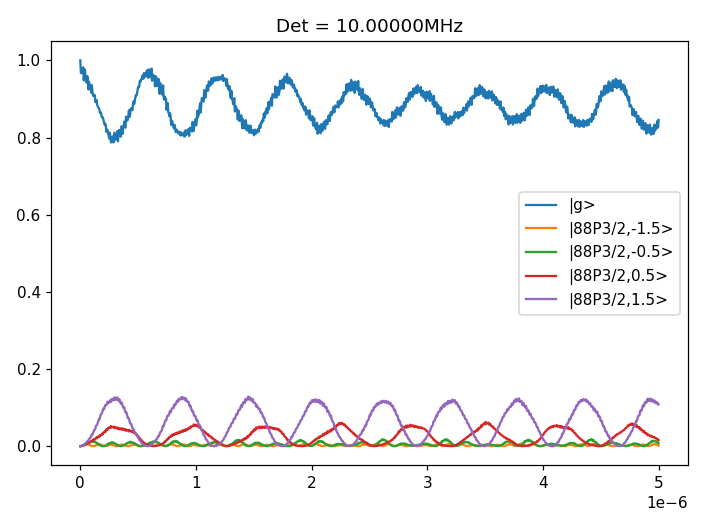

<IPython.core.display.Javascript object>


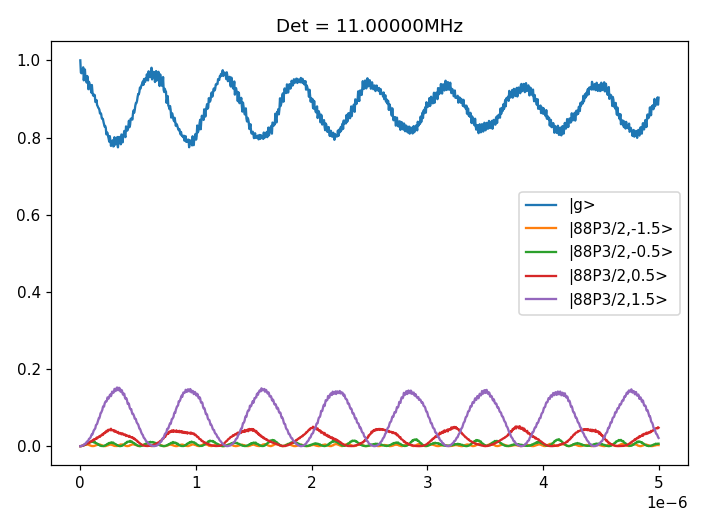

<IPython.core.display.Javascript object>


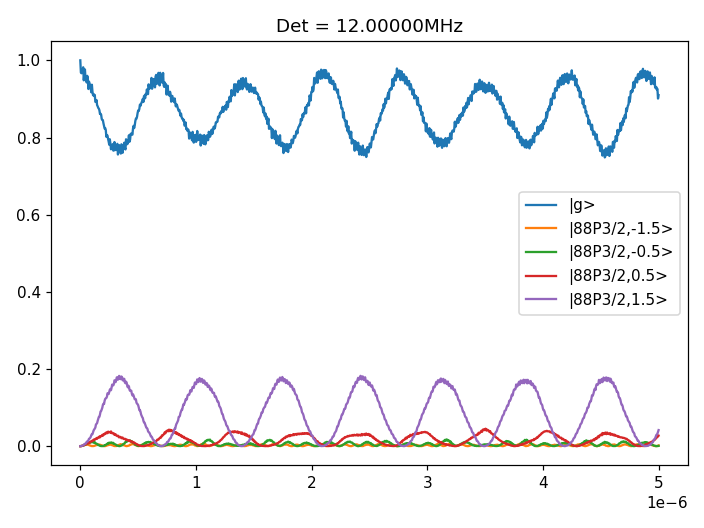

<IPython.core.display.Javascript object>


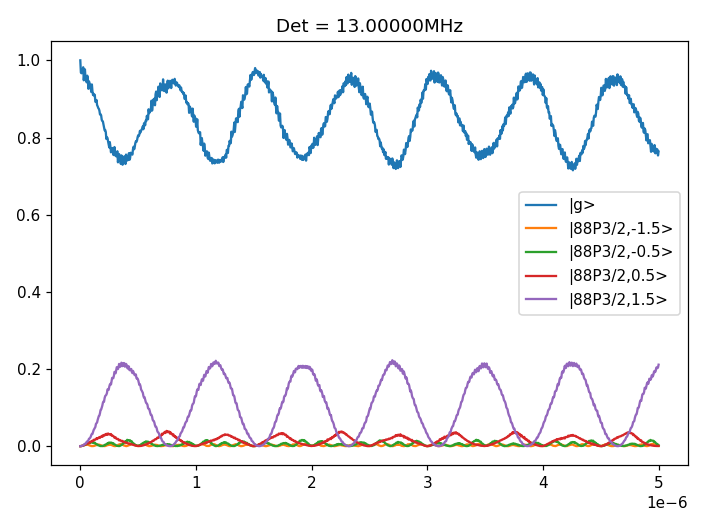

<IPython.core.display.Javascript object>


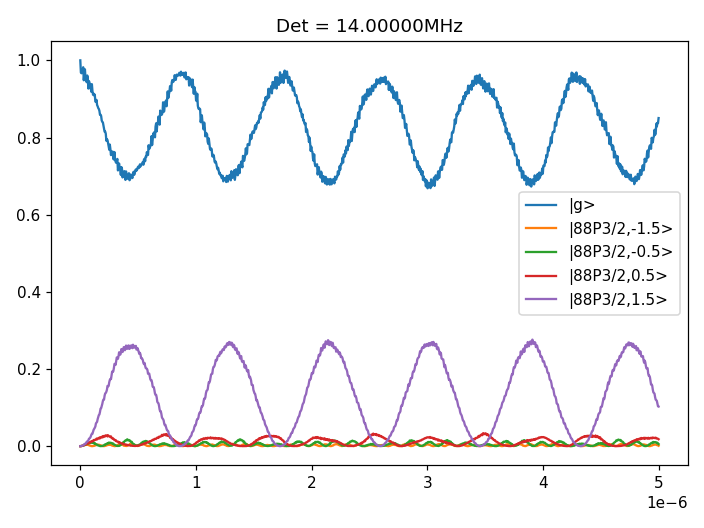

<IPython.core.display.Javascript object>


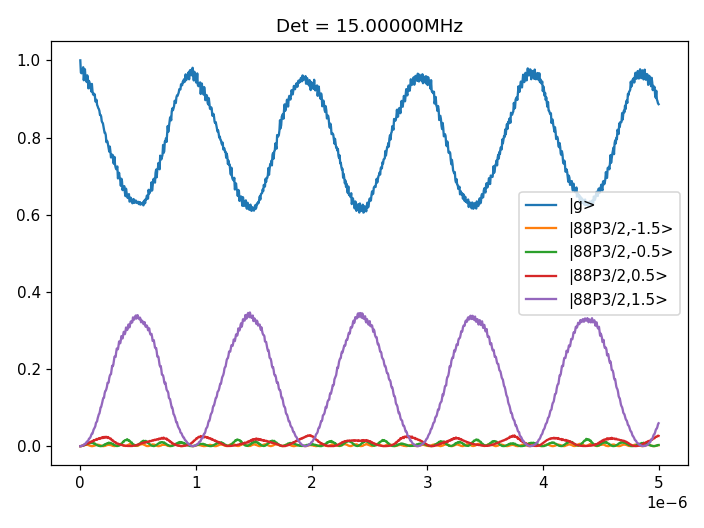

<IPython.core.display.Javascript object>


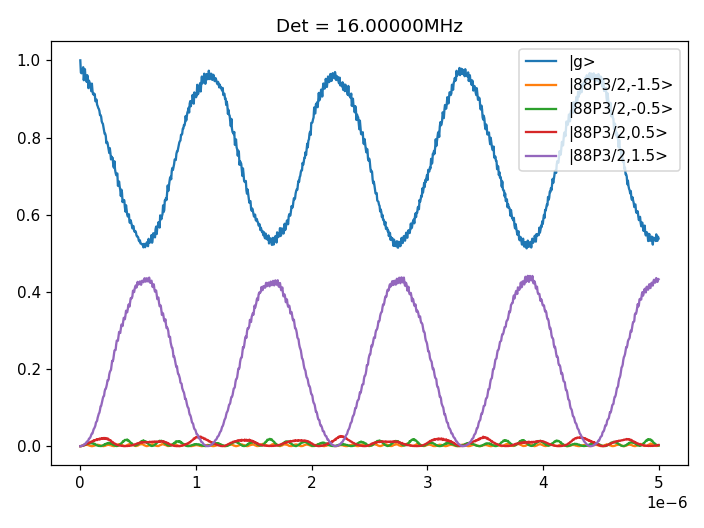

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
for i, det in enumerate(detunings):
    fig,ax = plt.subplots(1,1)
    ax.plot(ts,np.abs(ys[0,i,:])**2, label = "|g>")
    for mr in mrs:
        ax.plot(ts,np.abs(ys[ryd_ind(mr),i,:])**2, label=f"|{nr}P3/2,{mr}>")
    ax.set_title(f"Det = {det*1e-6:.5f}MHz")
    ax.legend()
    fig.tight_layout()
    fig.show()